## Algorithm logic is in Third last cell  with output and last cell has code  the debugging procedure with output 

In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, classification_report
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Import the train set prepared previously
train = pd.read_excel('train_prepared.xlsx')

# Check the shape and class distribution
print("Loaded data shape:", train.shape)
print("Class distribution:\n", train['TARGET'].value_counts())

Loaded data shape: (95617, 15)
Class distribution:
 TARGET
0    73640
1    21977
Name: count, dtype: int64


In [5]:
train.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,TARGET,credit_score_missing,Term_of_loan,Years_in_current__job
0,101332,713,3111440.0,39152.16,11.2,6,0,174895,328768,0,0,1,0,0,3
1,224532,600,1174238.0,13751.06,17.7,10,0,22268,314336,0,0,0,1,0,11
2,452892,750,2700736.0,20953.20,13.0,11,0,292980,764060,0,0,0,0,0,2
3,46332,600,1174238.0,18021.69,33.4,16,0,496014,641740,0,0,1,1,0,11
4,185328,723,914546.0,12575.15,11.7,8,0,29108,200640,0,0,0,0,1,11


In [6]:
test = pd.read_csv('test_set_cat.csv')

In [7]:
test.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,fc5bcf5b-35c3-4d1c-8f40-e71c92b3d17f,06b19e70-191a-4620-9ae8-6bb27e910528,Fully Paid,130174,Short Term,NaN,NaN,2 years,5396.00,10.5,18.0,11,0,80864,199650.0,0.0,0.0
1,260e82fe-00a0-4ebc-a940-de9700d43fba,8ecda87b-deb9-4376-92fe-7296cbd3f462,Fully Paid,98208,Short Term,723.0,834233.0,3 years,21689.83,22.9,46.0,18,0,189506,1160962.0,0.0,0.0
2,ce945b2a-da98-468c-ad7a-9c7738efaadf,37fe9f3e-f4bc-4df8-97ad-58d32470965f,Charged Off,325908,Long Term,707.0,705109.0,2 years,16511.19,15.4,NaN,8,1,86279,127270.0,1.0,0.0
3,fbd3da73-78e2-49c8-a822-985b21eea849,e6bf52d6-ec07-48a2-b129-4f423eff1ba5,Fully Paid,215754,Short Term,NaN,NaN,4 years,20918.81,10.9,NaN,9,1,50217,89474.0,1.0,0.0
4,26386194-7c88-49e3-b5f2-a4cb652ad3d8,a21a1ae7-0115-4b43-af4b-e82b7913685f,Fully Paid,198638,Long Term,686.0,764579.0,3 years,15533.83,18.1,32.0,10,0,94734,280500.0,0.0,0.0


In [8]:
test.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

# These two features are only for identification.Hence droping them

In [9]:
# # Missing Values

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(test)

# A curious thing about the table below is the last 10 features have the same number o missing values.
# I will go deeper and figure out what is happening.

Your selected dataframe has 15 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,2669,53.4
Annual Income,932,18.6
Credit Score,932,18.6
Years in current job,213,4.3
Bankruptcies,18,0.4
Maximum Open Credit,2,0.0
Tax Liens,2,0.0


In [11]:
# Drop the columns with > 50% missing
test.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

In [12]:
# test.drop(test.tail(514).index, inplace=True) # drop last 514 rows
missing_values_table(test)

Your selected dataframe has 14 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,932,18.6
Annual Income,932,18.6
Years in current job,213,4.3
Bankruptcies,18,0.4
Maximum Open Credit,2,0.0
Tax Liens,2,0.0


In [13]:
# As the number of missing values is so low in the 'Maximum Open Credit' I will drop them.

for i in test['Maximum Open Credit'][test['Maximum Open Credit'].isnull() == True].index:
    test.drop(labels=i, inplace=True)
missing_values_table(test)

Your selected dataframe has 14 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,931,18.6
Annual Income,931,18.6
Years in current job,213,4.3
Bankruptcies,18,0.4
Tax Liens,2,0.0


In [14]:
# As the number of missing values is so low in the 'Tax Liens' I will drop them.

for i in test['Tax Liens'][test['Tax Liens'].isnull() == True].index:
    test.drop(labels=i, inplace=True)
missing_values_table(test)

Your selected dataframe has 14 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,930,18.6
Annual Income,930,18.6
Years in current job,213,4.3
Bankruptcies,16,0.3


In [15]:
# As the number of missing values is so low in the 'Bankruptcies' I will drop them.

for i in test['Bankruptcies'][test['Bankruptcies'].isnull() == True].index:
    test.drop(labels=i, inplace=True)
missing_values_table(test)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,929,18.7
Annual Income,929,18.7
Years in current job,213,4.3


In [16]:
test.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,130174,Short Term,NaN,NaN,2 years,5396.00,10.5,11,0,80864,199650.0,0.0,0.0
1,Fully Paid,98208,Short Term,723.0,834233.0,3 years,21689.83,22.9,18,0,189506,1160962.0,0.0,0.0
2,Charged Off,325908,Long Term,707.0,705109.0,2 years,16511.19,15.4,8,1,86279,127270.0,1.0,0.0
3,Fully Paid,215754,Short Term,NaN,NaN,4 years,20918.81,10.9,9,1,50217,89474.0,1.0,0.0
4,Fully Paid,198638,Long Term,686.0,764579.0,3 years,15533.83,18.1,10,0,94734,280500.0,0.0,0.0


In [17]:
# Map values in 'loan_status' column /target column to numerical
test['TARGET'] = test['Loan Status'].map({
    'Fully Paid': 0, #non- Defaulter
    'Charged Off': 1 # defaulter
})


In [18]:
test = test.drop('Loan Status', axis=1)

In [19]:
test['credit_score_missing'] = test['Credit Score'].isna().astype(int)


In [20]:
test.head()

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,TARGET,credit_score_missing
0,130174,Short Term,NaN,NaN,2 years,5396.00,10.5,11,0,80864,199650.0,0.0,0.0,0,1
1,98208,Short Term,723.0,834233.0,3 years,21689.83,22.9,18,0,189506,1160962.0,0.0,0.0,0,0
2,325908,Long Term,707.0,705109.0,2 years,16511.19,15.4,8,1,86279,127270.0,1.0,0.0,1,0
3,215754,Short Term,NaN,NaN,4 years,20918.81,10.9,9,1,50217,89474.0,1.0,0.0,0,1
4,198638,Long Term,686.0,764579.0,3 years,15533.83,18.1,10,0,94734,280500.0,0.0,0.0,0,0


In [21]:
# Check average target value when credit score is missing vs not missing
print(test.groupby('credit_score_missing')['TARGET'].mean())


credit_score_missing
0    0.210318
1    0.294941
Name: TARGET, dtype: float64


In [22]:
test['Credit Score'] = test['Credit Score'].fillna(600)  # A conservative, lower-end score


In [23]:
# Calculate the mode of the column
mode_value = test['Years in current job'].mode()[0]

# Fill missing values with the mode
test['Years in current job'].fillna(mode_value, inplace=True)


C:\Users\easntop\AppData\Local\Temp\ipykernel_10680\3908443526.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Years in current job'].fillna(mode_value, inplace=True)


In [24]:
# Calculate the median of Annual Income
median_income = test['Annual Income'].median()

# Fill missing values with the median
test['Annual Income'].fillna(median_income, inplace=True)



C:\Users\easntop\AppData\Local\Temp\ipykernel_10680\3716808664.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Annual Income'].fillna(median_income, inplace=True)


In [25]:
for col in ['Credit Score', 'Annual Income']:
    q1 = np.percentile(train[col], 1)
    q99 = np.percentile(train[col], 99)
    train[col] = np.clip(train[col], q1, q99)  # modifies in-place as you want


In [26]:
# Assume your DataFrame is called 'df'
categorical_columns = test.select_dtypes(include=['object', 'category']).columns
num_categorical = len(categorical_columns)

print(f"Number of categorical features: {num_categorical}")
print("Categorical columns:")
print(categorical_columns.tolist())


Number of categorical features: 2
Categorical columns:
['Term', 'Years in current job']


In [27]:
# --------------------
# Encode 'Term' column
# --------------------
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}

test['Term_of_loan'] = test['Term'].map(term_mapping)

# -------------------------------
# Encode 'Years in current job'
# -------------------------------
def clean_years(value):
    # Handle "<1 year" as 0
    if '<1' in str(value):
        return 0
    # Handle "10+ years" as 10
    elif '10+' in str(value):
        return 11
    else:
        # Extract digits using regex (safe for cases like '2 years', '5 yrs')
        num = re.findall(r'\d+', str(value))
        return int(num[0]) if num else None  # None if no number found

test['Years_in_current__job'] = test['Years in current job'].apply(clean_years)

# --------------------
# Drop original columns if not needed
# --------------------
test.drop(['Term', 'Years in current job'], axis=1, inplace=True)

# --------------------
# Check the result
# --------------------
print(test[['Term_of_loan', 'Years_in_current__job']].head())


   Term_of_loan  Years_in_current__job
0             0                      2
1             0                      3
2             1                      2
3             0                      4
4             1                      3


In [28]:
test.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,TARGET,credit_score_missing,Term_of_loan,Years_in_current__job
0,130174,600.0,1167816.0,5396.00,10.5,11,0,80864,199650.0,0.0,0.0,0,1,0,2
1,98208,723.0,834233.0,21689.83,22.9,18,0,189506,1160962.0,0.0,0.0,0,0,0,3
2,325908,707.0,705109.0,16511.19,15.4,8,1,86279,127270.0,1.0,0.0,1,0,1,2
3,215754,600.0,1167816.0,20918.81,10.9,9,1,50217,89474.0,1.0,0.0,0,1,0,4
4,198638,686.0,764579.0,15533.83,18.1,10,0,94734,280500.0,0.0,0.0,0,0,1,3


In [29]:
X_test = test.drop(columns=['TARGET'])
y_test = test['TARGET']

In [30]:
X = train.drop('TARGET', axis=1)   
y = train['TARGET']

## Code Implementing Adaptive Quantile-Based Thresholding without DEBUG Statements

In [ ]:

# -------------------------
#  Gini Impurity
# -------------------------
def gini_impurity(y):
    counts = np.bincount(y)                           # counts how many times each class label appears.
    prob_sq_sum = np.sum((counts / len(y)) ** 2)      # probability squared sum
    return 1 - prob_sq_sum

# -------------------------
# Feature Importance 
# -------------------------
def compute_feature_importance(X, y):
    importances = []                                            # A python list list[floats]
    for i in range(X.shape[1]):                                 # loop over Number of column/features in dataset 
        try:                                                    # try catches Pearson error(constant values,Nan Values etc)
            corr, _ = pearsonr(X[:, i], y)                      # pearsonr-> function returns correlation coeff & X[:,i] -> Selects all rows and column i/feature i ,y -> Target
            importances.append(abs(corr))                       # Add the absolute value of corr to the list -> importance as corr -Correlation Coefficent can be a value between -1 and 1
        except Exception: 
            importances.append(0.0)                             # if any exception happens the importance is set 0 for that particular feature
    importances = np.nan_to_num(importances)
    return importances / (np.sum(importances) + 1e-8)           # normalizing the feature importance values.1e-8 is used so that denominator doesnt compeletly becomes zero

# importances = np.nan_to_num(importances) Pearson returns NaN silently for constant columns — no error raised — so the except block is never hit.
#                                           may later divide or sum NaNs — results in errors
# (np.sum(importances) + 1e-8)-> normalizes -> To scale all importances between 0 and 1
#                                            -> To ensure total importance sums to 1 (prob-like)

# -------------------------
# Single Quantile Decision Tree (with max_features)
# -------------------------
class RandomForestQuantileClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, feature_quantiles=None, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_quantiles = feature_quantiles
        self.max_features = max_features
        self.tree = None                                    # store the built tree structure (after .fit())

    def fit(self, X, y):    # starts looking at the train data to build tree
        self.n_classes_ = len(set(y))                       # Number of classes /TARGET
        self.n_features_ = X.shape[1]                       # Number of features
        self.tree = self._build_tree(X, y, depth=0)         # Start building the tree (recursive function) starting from root node (depth=0).

    def _build_tree(self, X, y, depth): #a recursive function to build tree
        num_samples, num_features = X.shape

        # Stopping conditions --->>>> # Stop splitting if depth or sample size or purity condition met otherwise split
        #This checks when to stop splitting and make a leaf node.
        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or len(set(y)) == 1:
            most_common = Counter(y).most_common(1)[0][0] #If all samples belong to the same class, no need to split
            return {'type': 'leaf', 'class': most_common}

        # Choose random subset of features (max_features)   
        #  ""  block controls feature randomness (feature bagging) "" 
        # """ Out of all features, which subset of features should I consider for splitting?  """

        if self.max_features is None:                # use all features available
            features_to_consider = np.arange(num_features) 
        elif isinstance(self.max_features, int):      # if max_features is an integer (like 3):randomly chosen 3 features out of 5
            features_to_consider = np.random.choice(num_features, self.max_features, replace=False)
        elif isinstance(self.max_features, float):    # If max_features is a float 
            n_feats = max(1, int(self.max_features * num_features))
            features_to_consider = np.random.choice(num_features, n_feats, replace=False)
        elif self.max_features == "sqrt":             ## If max_features is a float (like 9) : take 3
            n_feats = max(1, int(np.sqrt(num_features)))
            features_to_consider = np.random.choice(num_features, n_feats, replace=False)
        else:
            raise ValueError("Invalid max_features value")

        # Find best split over these features
        best_gini = 1.0                     # (maximum impurity, worst possible) Lower Gini = better split (purer node).
        best_split = None                   # No split chosen yet (None)

        for feature_idx in features_to_consider:
            n_quantiles = self.feature_quantiles.get(feature_idx, 10) #If that feature is not present in the dictionary (maybe due to some missing calculation or initialization issue), then default to 10 quantiles.
                                                                     # retrieves how many quantiles to consider for this feature.For the current feature only, it stores how many quantiles to use to find candidate split points.
            unique_vals = np.unique(X[:, feature_idx])               # extracts all distinct (unique) values present in that feature across the bootstrapped data.
            if len(unique_vals) == 1:                          #If only 1 unique value exists, then this feature cannot be split — because there's nothing to divide.
                continue                                       #So the code skips this feature (continue) and moves to the next feature.

            thresholds = np.unique(np.quantile(X[:, feature_idx], np.linspace(0, 1, n_quantiles + 2)[1:-1])) # "Find possible threshold points to split this feature at, using quantiles.

            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold           # has values of feature less than threshold ,datatype of left_mask is boolean numpy array
                right_mask = X[:, feature_idx] > threshold           # has values of feature more than threshold
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue                      #If **either left or right node gets zero samples — i.e. no data fell on that side of the split — then this threshold is invalid. go to next

                y_left, y_right = y[left_mask], y[right_mask]
                gini = (len(y_left) / num_samples) * gini_impurity(y_left) + \
                       (len(y_right) / num_samples) * gini_impurity(y_right)   # calculates total/weighted gini using gini of individual left node and right node gini

                if gini < best_gini:
                    best_gini = gini            # updating best gini if lower gini is found
                    best_split = {               #stores details of best split
                        'feature': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_mask,
                        'right_indices': right_mask
                    }

        if best_split is None:         # "If no good split exists, stop splitting and make this node predict the majority class seen so far."
            most_common = Counter(y).most_common(1)[0][0]  #finds the majority class label of the samples present at this node.
            return {'type': 'leaf', 'class': most_common}
        
        left_subtree = self._build_tree(X[best_split['left_indices']], y[best_split['left_indices']], depth + 1) # recursive call for left node
        right_subtree = self._build_tree(X[best_split['right_indices']], y[best_split['right_indices']], depth + 1) #  recursive call for right node

        return {   #after each node is constructed return stores the deatils of the each node of tree and returns it in recursive manner
            'type': 'node',
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

# core function used to predict the class label of a single data sample x 
# by traversing the decision tree from the root to the appropriate leaf node.
    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])
     #Predict one sample at a time using _predict_sample()
    #Collect all results into an array of predictions.
    #Used by predict(X_test) to predict entire test sets.


# -------------------------
# Ensemble of Decision  Trees (Quantile-based, with n_jobs for parallel)
# -------------------------
class RandomforestQuantileEnsembleClassifier:
    def __init__(self, n_estimators=5, max_depth=None, min_samples_split=2,
                 max_quantiles=200, min_quantiles=3, max_features=None, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_quantiles = max_quantiles
        self.min_quantiles = min_quantiles
        self.max_features = max_features
        self.n_jobs = n_jobs  # Added for multiprocessing
        self.trees = []
        #The quantile_map dictionary, which stores how many quantiles to assign for each feature,is saved in the model’s object (self) as self.feature_quantiles.

    def fit(self, X, y):
        # Calculate feature importance (Pearson) for quantile assignment
        feature_importances = compute_feature_importance(X, y)            # compute_feature_importance returns normalized importance values for each feature in X           
        quantile_map = {}                                                 # an empty dictionary to store how many quantiles each feature will get

        for i, imp in enumerate(feature_importances):                     # Loop over each feature (by index i) and its importance imp.
            quant_count = int(self.min_quantiles + imp * (self.max_quantiles - self.min_quantiles)) # based on its importance calculate number of quantiles (quant_count) to use for the feature 
            quantile_map[i] = max(self.min_quantiles, quant_count)        # max(self.min_quantiles, quant_count) ensures no feature gets less than the minimum allowed quantiles — for safety.

        self.feature_quantiles = quantile_map                        # maps features to quantiles  self.feature_quantiles = {0: 101, 1: 62, 2: 42}

        def build_tree(X, y):
            indices = np.random.choice(len(X), len(X), replace=True) # Draw random sample indices (bootstrapping) (range of values to sample from,values to draw, with replacement)
            X_sample = X[indices]                                    # Give those specific rows from X, in the order given by indices (rows selected in previous step)
            y_sample = y[indices]                                    # Give the target values (labels) for those particular rows stored in x_sample

            tree = RandomForestQuantileClassifier(max_depth=self.max_depth,                 # how deep it can go (limit recursion depth)
                                               min_samples_split=self.min_samples_split, # when to stop splitting,
                                               feature_quantiles=self.feature_quantiles, # how many quantiles to use for each feature (calculated earlier)
                                               max_features=self.max_features)           # how many features to consider at each split.
            tree.fit(X_sample, y_sample)       # train (fit) this tree on X_sample, y_sample
            return tree

        # Parallel tree building here - helps reducing predictiontime as it uses all cores
        self.trees = Parallel(n_jobs=self.n_jobs)(
            delayed(build_tree)(X, y) for _ in range(self.n_estimators)
        )

    def predict(self, X):# is only called at prediction time on .predict(X_test)
        # Parallel prediction for each tree
        all_predictions = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(lambda tree: tree.predict(X))(tree) for tree in self.trees
            )
        )
        # Majority vote along axis=0
        return np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=all_predictions
        )
                  #It applies a function to 1D slices (rows or columns) of a multi-dimensional NumPy array.

                  # self.trees is a list of trained individual decision trees in our ensemble.
                  # For each tree in this list, we are calling its own .predict(X) method
                  # "Make each tree predict all samples in X — collect all these predictions in a 2D array — one row per tree."

# Test

if __name__ == "__main__":

    clf = RandomforestQuantileEnsembleClassifier(n_estimators=30, max_quantiles=200, 
                                                 min_quantiles=10, n_jobs=-1)  # n_jobs=-1 to use all cores
    clf.fit(X.values, y.values) #Fitting model on train data
    y_pred = clf.predict(X_test.values) #fitting model on test data
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8893574297188755
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      3854
           1       0.86      0.61      0.71      1126

    accuracy                           0.89      4980
   macro avg       0.88      0.79      0.82      4980
weighted avg       0.89      0.89      0.88      4980



### prints the roc_acu curve

ROC AUC Score: 0.895663982243541


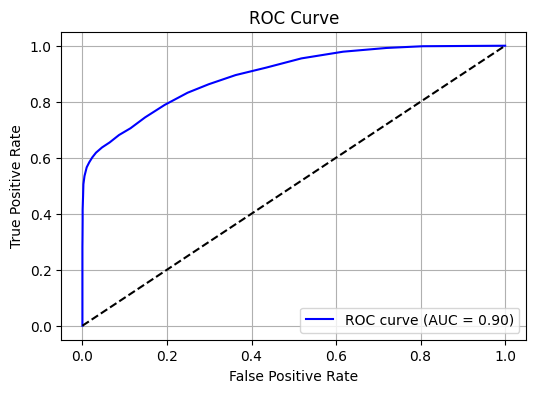

In [38]:

# -------------------------
# Confusion Matrix
# -------------------------
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------
# ROC AUC Score and ROC Curve Plot
# -------------------------
try:
    # Collect all tree predictions (shape: n_estimators x n_samples)
    tree_preds = np.array([tree.predict(X_test.values) for tree in clf.trees])

    # Convert string labels to 0/1 if needed
    if isinstance(y_test[0], str):   # if target labels are strings (e.g. 'yes', 'no')
        le = LabelEncoder()
        y_test_num = le.fit_transform(y_test)  # encode true labels
        tree_preds_num = np.array([le.transform(preds) for preds in tree_preds])  # encode each tree's predictions
    else:  # if already numeric (e.g. 0/1)
        y_test_num = y_test
        tree_preds_num = tree_preds

    # Estimate probability of class '1' by averaging tree votes
    y_proba = np.mean(tree_preds_num == 1, axis=0)

    # ROC AUC Score
    auc_score = roc_auc_score(y_test_num, y_proba)
    print("ROC AUC Score:", auc_score)

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test_num, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

except Exception as e:
    print("ROC AUC computation failed:", e)


Same code is written below but with modification [Debug statements]

* Print all candidate thresholds generated (based on quantiles) — these are simply the thresholds calculated before any split evaluation (Gini impurity).

For each threshold, print the calculated Gini impurity value — this tells us how well that threshold split the data.

**Print the threshold which gave the minimum Gini impurity — i.e., the threshold that was actually selected for splitting at the root node.

In [ ]:
# -------------------------
# Gini Impurity
# -------------------------
def gini_impurity(y):
    counts = np.bincount(y)
    prob_sq_sum = np.sum((counts / len(y)) ** 2)
    return 1 - prob_sq_sum

# -------------------------
# Feature Importance Calculation (Pearson)
# -------------------------
def compute_feature_importance(X, y):
    importances = []
    for i in range(X.shape[1]):
        try:
            corr, _ = pearsonr(X[:, i], y)
            importances.append(abs(corr))
        except Exception:
            importances.append(0.0)
    importances = np.nan_to_num(importances)s
    norm_importances = importances / (np.sum(importances) + 1e-8)
    return norm_importances

# -------------------------
# Single Quantile Decision Tree (Custom)
# -------------------------
class RandomForestQuantileClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, feature_quantiles=None, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_quantiles = feature_quantiles
        self.max_features = max_features
        self.tree = None
        self.feature_thresholds_ = {}  # store thresholds

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        print(f"\n[DEBUG] Fitting a tree with {self.n_features_} features and {len(y)} samples.")
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape

        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or len(set(y)) == 1:
            most_common = Counter(y).most_common(1)[0][0]
            return {'type': 'leaf', 'class': most_common}

        if self.max_features is None:
            features_to_consider = np.arange(num_features)
        elif isinstance(self.max_features, int):
            features_to_consider = np.random.choice(num_features, self.max_features, replace=False)
        elif isinstance(self.max_features, float):
            n_feats = max(1, int(self.max_features * num_features))
            features_to_consider = np.random.choice(num_features, n_feats, replace=False)
        elif self.max_features == "sqrt":
            n_feats = max(1, int(np.sqrt(num_features)))
            features_to_consider = np.random.choice(num_features, n_feats, replace=False)
        else:
            raise ValueError("Invalid max_features value")

        best_gini = 1.0
        best_split = None

        for feature_idx in features_to_consider:
            n_quantiles = self.feature_quantiles.get(feature_idx, 10)
            unique_vals = np.unique(X[:, feature_idx])
            if len(unique_vals) <= 1:
                continue  # Skip constant or single-value features

            # Safe quantile thresholds
            if len(unique_vals) <= n_quantiles:
                thresholds = unique_vals[:-1]  # Skip the max value to avoid empty split
            else:
                thresholds = np.unique(np.quantile(X[:, feature_idx],
                               np.linspace(0, 1, n_quantiles + 2)[1:-1]))
            self.feature_thresholds_[feature_idx] = thresholds
            # >>>> TEMP DEBUG: Print all candidate thresholds at root node <<<<<
            # if depth == 0:
            #     print(f"Feature {feature_idx}: All candidate thresholds tried at root => {thresholds}")

            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                gini = (len(y_left) / num_samples) * gini_impurity(y_left) + \
                       (len(y_right) / num_samples) * gini_impurity(y_right)

                if gini < best_gini:
                    best_gini = gini
                    best_split = {
                        'feature': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_mask,
                        'right_indices': right_mask
                    }

        if best_split is None:
            most_common = Counter(y).most_common(1)[0][0]
            return {'type': 'leaf', 'class': most_common}
        
        # New Debug Print: Show final chosen threshold at root
        if depth == 0:
           print(f"[FINAL CHOICE at Root Node] Feature {best_split['feature']} splits at threshold: {best_split['threshold']} with Gini: {best_gini}")

        left_subtree = self._build_tree(X[best_split['left_indices']], y[best_split['left_indices']], depth + 1)
        right_subtree = self._build_tree(X[best_split['right_indices']], y[best_split['right_indices']], depth + 1)

        return {
            'type': 'node',
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

# -------------------------
# Random Forest Ensemble (Quantile-based, n_jobs)
# -------------------------
class RandomforestQuantileEnsembleClassifier:
    def __init__(self, n_estimators=5, max_depth=None, min_samples_split=2,
                 max_quantiles=200, min_quantiles=3, max_features=None, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_quantiles = max_quantiles
        self.min_quantiles = min_quantiles
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.trees = []

    def fit(self, X, y):
        feature_importances = compute_feature_importance(X, y)
        quantile_map = {}
        for i, imp in enumerate(feature_importances):
            quant_count = int(self.min_quantiles + imp * (self.max_quantiles - self.min_quantiles))
            quantile_map[i] = max(self.min_quantiles, quant_count)

        self.feature_quantiles = quantile_map
        print("\n[DEBUG] Quantiles assigned to features:")
        for feature_idx, q_count in quantile_map.items():
            print(f"Feature {feature_idx}: {q_count} quantiles")

        def build_tree(X, y):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = RandomForestQuantileClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                feature_quantiles=self.feature_quantiles,
                max_features=self.max_features
            )
            tree.fit(X_sample, y_sample)
            return tree

        self.trees = Parallel(n_jobs=self.n_jobs)(
            delayed(build_tree)(X, y) for _ in range(self.n_estimators)
        )

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

# -------------------------
# Test Run Example
# -------------------------
if __name__ == "__main__":
    clf = RandomforestQuantileEnsembleClassifier(n_estimators=40, max_quantiles=200, min_quantiles=10, n_jobs=-1)
    clf.fit(X.values, y.values)
    # Debugging for Tree 0 only (root node)
tree = clf.trees[0]
print("\n[DEBUG] ===== Detailed Threshold and Gini Calculation for Tree 0 Root Node =====")

X_sample = X.values  # Full train data used during fit
y_sample = y.values

# Simulate what happened in _build_tree at depth=0
feature_importances = compute_feature_importance(X_sample, y_sample)
n_features = X_sample.shape[1]

best_gini = 1.0
best_split = None

for feature_idx in range(n_features):
    n_quantiles = clf.feature_quantiles.get(feature_idx, 10)
    unique_vals = np.unique(X_sample[:, feature_idx])

    if len(unique_vals) <= 1:
        continue  # skip constant feature

    # Calculate quantile thresholds safely
    if len(unique_vals) <= n_quantiles:
        thresholds = unique_vals[:-1]
    else:
        thresholds = np.unique(np.quantile(X_sample[:, feature_idx], np.linspace(0, 1, n_quantiles + 2)[1:-1]))

    if len(thresholds) == 0:
        continue  # nothing to test

    print(f"\n[DEBUG] Feature {feature_idx}: Total {len(thresholds)} candidate thresholds computed: {thresholds}")

    for threshold in thresholds:
        left_mask = X_sample[:, feature_idx] <= threshold
        right_mask = X_sample[:, feature_idx] > threshold
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            continue  # invalid split

        y_left, y_right = y_sample[left_mask], y_sample[right_mask]
        gini = (len(y_left) / len(y_sample)) * gini_impurity(y_left) + \
               (len(y_right) / len(y_sample)) * gini_impurity(y_right)

        print(f"    Threshold {threshold:.4f}: Gini Impurity = {gini:.6f}")

        if gini < best_gini:
            best_gini = gini
            best_split = {'feature': feature_idx, 'threshold': threshold, 'gini': gini}

if best_split:
    print("\n[RESULT] Best split at root node in Tree 0:")
    print(f"    Feature {best_split['feature']} | Threshold: {best_split['threshold']} | Gini: {best_split['gini']:.6f}")
else:
    print("\n[RESULT] No valid split found at root node in Tree 0.")

    y_pred = clf.predict(X_test.values)
    print("\nAccuracy:", accuracy_score(y_test.values, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

   # Access and print thresholds for each tree
# for i, tree in enumerate(clf.trees):
#     print(f"\n[DEBUG] ===== Tree {i} Root Node Threshold Summary =====")
#     for feature_idx, thresholds in tree.feature_thresholds_.items():
#         if len(thresholds) == 0:
#             print(f"Feature {feature_idx}: [No candidate thresholds calculated at root node] (Reason: Possibly constant feature or not eligible for splitting at root)")
#         else:
#             print(f"Feature {feature_idx}: Calculated {len(thresholds)} unique candidate thresholds at the root node (after removing redundant or identical thresholds).")
#             print(f"            These are the candidate thresholds tried => {thresholds}")
            # print(f"            [NOTE] Out of these, the threshold that results in the lowest Gini impurity is finally selected for the actual split at this node.")
#     used_features = [k for k, v in tree.feature_thresholds_.items() if len(v) > 0]
#     print(f"[INFO] In Tree {i}: {len(used_features)} features had candidate thresholds calculated at the root node.")
#     print("[NOTE] These displayed thresholds are only for the root node. At deeper nodes, thresholds are recalculated dynamically during tree growth and are not stored here.")



[DEBUG] Quantiles assigned to features:
Feature 0: 68 quantiles
Feature 1: 40 quantiles
Feature 2: 32 quantiles
Feature 3: 12 quantiles
Feature 4: 17 quantiles
Feature 5: 13 quantiles
Feature 6: 10 quantiles
Feature 7: 13 quantiles
Feature 8: 12 quantiles
Feature 9: 12 quantiles
Feature 10: 13 quantiles
Feature 11: 29 quantiles
Feature 12: 42 quantiles
Feature 13: 10 quantiles

[DEBUG] ===== Detailed Threshold and Gini Calculation for Tree 0 Root Node =====

[DEBUG] Feature 0: Total 62 candidate thresholds computed: [4.37360000e+04 6.01365217e+04 6.74740000e+04 8.20600000e+04
 9.01780000e+04 1.05072000e+05 1.09252000e+05 1.12156000e+05
 1.23398000e+05 1.30922000e+05 1.34354000e+05 1.43107130e+05
 1.53164000e+05 1.58598000e+05 1.70456000e+05 1.75032000e+05
 1.78750000e+05 1.87000000e+05 1.97362000e+05 2.07152000e+05
 2.15182000e+05 2.17514000e+05 2.20000000e+05 2.22546261e+05
 2.24818000e+05 2.35598000e+05 2.46268000e+05 2.58302000e+05
 2.62007565e+05 2.65496000e+05 2.69104000e+05 2.80